In [1]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [3]:
MAX_SAMPLES=10000
MAX_WORDS=20000
BATCH_SIZE=122
EPOCHS=1
OOV_TOKEN=0
EMBEDDING_DIM = 100
MAX_SEQ_LENGTH=100
VALIDATION_SPLIT_RATIO= 0.2
LSTM_UNITS=200

In [4]:
# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1

t = 0
for line in open('./data/deu.txt', encoding='utf-8'):
    t+=1
    if t>MAX_SAMPLES :
        break
        
    input_txt, target_txt = line.rstrip().split ('\t')
    
    target_txt_input = '<sos> '+target_txt
    target_txt = target_txt +' <eos>'
    
    input_texts.append (input_txt)
    target_texts_inputs.append(target_txt_input)
    target_texts.append(target_txt)
    
print ('Num samples is %d'%(len(input_texts)))

Num samples is 10000


In [5]:
en_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN, filters='')
en_tokenizer.fit_on_texts(input_texts)
en_word2Idx = en_tokenizer.word_index
en_num_words = len(en_word2Idx)+1
en_input_sequences = en_tokenizer.texts_to_sequences(input_texts)
max_seq_len_en = min (MAX_SEQ_LENGTH, max(len(s) for s in en_input_sequences))
padded_input_sequences = tf.keras.preprocessing.sequence.pad_sequences(en_input_sequences, padding='post', maxlen=max_seq_len_en)

print ('Max seq length of english sentences is %d'%(max_seq_len_en))
print ('Found %d unique english words'%(en_num_words))

Max seq length of english sentences is 5
Found 3131 unique english words


In [6]:
de_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_WORDS, oov_token=OOV_TOKEN, filters='')
de_tokenizer.fit_on_texts(target_texts+target_texts_inputs)
de_word2Idx = de_tokenizer.word_index

de_num_words = len(de_word2Idx)+1
print ('Found %d unique german words'%(de_num_words))

de_target_inputs_sequences = de_tokenizer.texts_to_sequences(target_texts_inputs) # this is for decoder input
de_target_sequences = de_tokenizer.texts_to_sequences(target_texts) # this is for decoder output

max_seq_len_target_inputs = min (MAX_SEQ_LENGTH, max(len(s) for s in de_target_inputs_sequences))
max_seq_len_target = min (MAX_SEQ_LENGTH, max(len(s) for s in de_target_sequences))

print ('Max seq length of german target sentences is %d'%(max_seq_len_target))
print ('Max seq length of german target input sentences is %d'%(max_seq_len_target_inputs))

padded_target_input_sequences = tf.keras.preprocessing.sequence.pad_sequences(de_target_inputs_sequences, padding='post', maxlen=max_seq_len_target_inputs)
padded_target_sequences = tf.keras.preprocessing.sequence.pad_sequences(de_target_sequences, padding='post', maxlen=max_seq_len_target)

assert ('<sos>' in de_word2Idx)

Found 5042 unique german words
Max seq length of german target sentences is 11
Max seq length of german target input sentences is 11


#### Load GloVe embeddings

In [7]:
embeddings_index = {}

f = open ('../glove.6B.100d.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word]=coefs

f.close()
print ('Found %s word embeddings'%(len(embeddings_index)))

Found 400000 word embeddings


In [8]:
num_words = min (MAX_WORDS, len(en_word2Idx)+1)
print ('Min words to be considered are %d'%(num_words))

loaded_embeddings_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in en_word2Idx.items():
    if (i<num_words):
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index[word]
            loaded_embeddings_matrix[i] = embedding_vector

print (loaded_embeddings_matrix.shape)

Min words to be considered are 3131
(3131, 100)


In [9]:
one_hot_targets = np.zeros((len(padded_target_sequences), max_seq_len_target, de_num_words),dtype='float32')
print (one_hot_targets.shape)
for i, seq in enumerate(padded_target_sequences):
    for j, word in enumerate(seq):
        if (word>0):
            one_hot_targets[i,j,word]=1

(10000, 11, 5042)


In [10]:
embed_layer = tf.keras.layers.Embedding(input_dim = en_num_words,
                               output_dim = EMBEDDING_DIM,
                               input_length=max_seq_len_en, 
                               embeddings_initializer=tf.keras.initializers.Constant(loaded_embeddings_matrix),
                               trainable=True)

In [11]:
##### build the encoder model #####
encoder_input_ = tf.keras.layers.Input(shape=(max_seq_len_en))
encoder_x = embed_layer(encoder_input_)
encoder_lstm_layer_0 = tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True, return_state=True)
encoder_x,h,c = encoder_lstm_layer_0(encoder_x)
encoder_states = [h, c]

W0915 00:17:05.775392  8628 deprecation.py:506] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
##### build the decoder model #####
decoder_input_ = tf.keras.layers.Input(shape=(max_seq_len_target_inputs))
target_embed_layer = tf.keras.layers.Embedding(input_dim = de_num_words,
                               output_dim = EMBEDDING_DIM,
                               input_length=max_seq_len_target_inputs, 
                               trainable=True)
decoder_x = target_embed_layer(decoder_input_)
decoder_lstm_layer_0 = tf.keras.layers.LSTM(units=LSTM_UNITS, return_sequences=True, return_state=True)
decoder_x,_,_ = decoder_lstm_layer_0(decoder_x, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(de_num_words, activation='softmax')
decoder_outputs = decoder_dense(decoder_x)

W0915 00:17:06.301604  8628 deprecation.py:506] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
##### build the encoder-decoder model #####
model = tf.keras.models.Model([encoder_input_, decoder_input_], decoder_outputs)
model.compile (optimizer=tf.keras.optimizers.Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       313100      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 100)      504200      input_2[0][0]                    
______________________________________________________________________________________________

In [14]:
history = model.fit ([padded_input_sequences,padded_target_input_sequences], one_hot_targets, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALIDATION_SPLIT_RATIO)

W0915 00:17:22.639512  8628 deprecation.py:323] From C:\MachineLearning\anaconda\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8000 samples, validate on 2000 samples


MemoryError: 

# Visualize the Training Metadata (Accuracy & Loss)

NameError: name 'history' is not defined

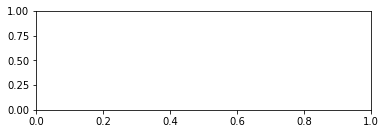

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(labels=['Training','Validation'])

ax1 = figure.add_subplot(212)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

In [ ]:
# Save model
model.save('s2s.h5')

In [22]:
##### Create Encoder Model for Inference ######
encoder_model = tf.keras.models.Model(encoder_input_, encoder_states)

decoder_state_input_h = tf.keras.layers.Input(shape=(LATENT_DIM,))
decoder_state_input_c = tf.keras.layers.Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = tf.keras.layers.Input(shape=(1,))
decoder_inputs_single_x = target_embed_layer(decoder_inputs_single)
decoder_ouput_single_x, h,c = decoder_lstm_layer_0(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [h, c]

decoder_outputs = decoder_dense(decoder_ouput_single_x)

decoder_model = tf.keras.models.Model(
  [decoder_inputs_single, decoder_states_inputs], 
  [decoder_outputs, decoder_states]
)

NameError: name 'LATENT_DIM' is not defined

In [19]:
# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in en_word2Idx.items()}
idx2word_trans = {v:k for k, v in de_word2Idx.items()}

In [23]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    encoder_states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    
    target_seq[0, 0] = de_word2Idx['<sos>']
    
    output_sentence = []
    for _ in range (len(de_target_inputs_sequences)):
        output_tokens, h,c = decoder_model.predict([target_seq,encoder_states_value])
        
        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])
        if idx == eos:
            print ('stopping...')

        word = ''
        if idx >0 :
            word = idx2word_trans[idx]
            output_sentence.append(word)
        
        target_seq[0, 0] = idx
            
        encoder_states_value = [h,c]
    
    return ' '.join(output_sentence)

In [24]:
test_sentence = encoder_input_[100]
print ('Input -', input_texts[100])
translated = decode_sequence (test_sentence)
print ('Translated -', translated)

Input - Go away!


ValueError: When using data tensors as input to a model, you should specify the `steps` argument.